## HMM Based POS Tagging Assignment
### Author - Kumaraguru Muthuraj

#### Solution description
1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Checking accuracy on the test data set

### 1. Exploring the treebank dataset -  data preparation

In [3]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [6]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\kumaraguru\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\kumaraguru\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [7]:
# Load the UNIVERSAL tagset from Treebank
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [27]:
# PRINT first few tagged sentences
print("***Length of the data set **** ", len(nltk_data))
# samples: Each sentence is a list of (word, pos) tuples
print("\n\n***First few lines*****")
nltk_data[:5]

***Length of the data set ****  3914


***First few lines*****


[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [28]:
#5% of data, according to https://learn.upgrad.com/v/course/1120/session/169917/segment/904732
TEST_DATA_PERCENT = 0.05 

# Splitting into train and test
train_set, test_set = train_test_split(nltk_data, test_size = TEST_DATA_PERCENT)

print("***Length of the training data set **** ", len(train_set))
print("***Length of the test data set **** ", len(test_set))

print("\n\n*****Print a few lines*****\n", train_set[:5])

***Length of the training data set ****  3718
***Length of the test data set ****  196


*****Print a few lines*****
 [[('They', 'PRON'), ('do', 'VERB'), ("n't", 'ADV'), ('have', 'VERB'), ('plans', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('cut', 'VERB'), ('back', 'ADV'), ('.', '.')], [('Currently', 'ADV'), (',', '.'), ('the', 'DET'), ('government', 'NOUN'), ('charges', 'VERB'), ('nothing', 'NOUN'), ('for', 'ADP'), ('such', 'ADJ'), ('filings', 'NOUN'), ('.', '.')], [('``', '.'), ('Little', 'ADV'), ('by', 'ADP'), ('little', 'ADV'), (',', '.'), ('there', 'DET'), ('is', 'VERB'), ('progress', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('the', 'DET'), ('MITI', 'NOUN'), ('official', 'NOUN'), ('.', '.')], [('In', 'ADP'), ('1979', 'NUM'), (',', '.'), ('Hearst', 'NOUN'), ('hired', 'VERB'), ('editor', 'NOUN'), ('James', 'NOUN'), ('Bellows', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-48', 'X'), ('brightened', 'VERB'), ('the', 'DET'), ('editorial', 'NOUN'), ('product', 'NOUN')

In [29]:
# Getting list of tagged words
train_wordAndTag_list = [wordAndTag for sentence in train_set for wordAndTag in sentence]
len(train_wordAndTag_list)

95515

In [31]:
train_wordAndTag_list[:5]

[('They', 'PRON'),
 ('do', 'VERB'),
 ("n't", 'ADV'),
 ('have', 'VERB'),
 ('plans', 'NOUN')]

In [36]:
#Get the set of words from the train_wordAndTag_list.
tokens_set = set([wordAndTag[0] for wordAndTag in train_wordAndTag_list])
print(len(tokens_set))
print(tokens_set)

12097
{'local', 'Univest', 'pleased', 'mention', 'Centerbank', '3.16', 'futures-related', 'chronicle', 'Gelles', 'Experts', 'Tire', 'photograph', 'litigation', 'lobbyists', 'promised', 'Long', 'ambitions', 'ratified', 'executed', 'ChemPlus', 'Aslacton', 'existing', 'cult', 'S&L', 'several', '*T*-90', 'Taiwan', 'exceptionally', 'sacrificing', 'Computer', 'shallow', 'protections', 'Meinders', 'interrogation', 'accept', 'sounds', 'Renaissance-style', 'length', 'compound', 'Bates', 'mania', 'four-year-old', 'bag', 'schools', '1,570', 'chalk', 'stake', 'leapt', 'seriously', 'concentration', 'untrained', 'Midwesco', '2.875', 'Germany', 'coliseum', 'depressions', 'need', 'twin', 'Legislation', 'My', 'valuations', 'hotels', 'instead', 'Justice', 'stretched', 'labor-backed', 'F.H.', 'Heritage', 'INTER-TEL', '77', 'activity', 'Orders', 'skyward', '11,762', 'Gringo', 'betrayer', 'close', 'Brownstein', 'life-style', 'happened', 'Peng', 'prominently', 'descending', 'fresh', 'yield', 'remarked', 'ye

In [34]:
#How do we know if Universal tagset is used?
#Get the set of tags from the train_wordAndTag_list.
#It should be 12, as mentioned in the problem statement
#NOTE that this will be used shortly for the HMM algorithm
universal_tagset = set([wordAndTag[1] for wordAndTag in train_wordAndTag_list])
print(len(universal_tagset))
print(universal_tagset)

12
{'ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X'}


### 2. POS Tagging Algorithm - HMM - Build the vanilla Viterbi based POS tagger
#### Note: extracted from Upgrad Course - NLP - Module 2 - Exercise
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word W, assign the tag T that maximises the likelihood P(T/W). Since P(T/W) = P(W/T). P(T) / P(W), after ignoring P(W), we have to compute P(W/T) and P(T).

P(W/T) is basically the probability that given a tag (say NN), what is the probability of it being W (say 'building'). This can be computed by computing the fraction of all NNs which are equal to W, i.e.

P(W/T) = count(W, T) / count(T).

The term P(T) is the probability of tag T, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag T(n-1). So for e.g. if T(n-1) is a JJ, then T(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(W/T) and P(T) and store them in two large matrices. The matrix of P(W/T) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

### Emission Probabilities

In [40]:
# Computing P(W/T) and storing in tags x words matrix
tags = len(universal_tagset)
words = len(tokens_set)
prob_W_given_T = np.zeros((tags, words))

In [41]:
# Compute Emission Probability: word given tag 
def word_given_tag(word, tag, train_bag = train_wordAndTag_list):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [46]:
# examples

#'ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X'

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'DET'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'ADV'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(26, 6096)
(0, 12891)
(0, 8249) 


 will
(0, 3003)
(1, 27373)
(262, 12891)

 book
(7, 27373)
(0, 12891)


In [69]:
type(train_wordAndTag_list)

list

### Transition Probabilities

In [48]:
# compute tag2 happening given tag1: tag2(t2) given tag1(t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_wordAndTag_list):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [49]:
# examples
#'ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X'

print(t2_given_t1(t2='VERB', t1='NOUN'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('ADV', 'DET'))
print(t2_given_t1('NNP', 'VERB'))
print(t2_given_t1(',', 'X'))
print(t2_given_t1('PRT', 'NUM'))
print(t2_given_t1('DET', 'CONJ'))

(4032, 27373)
(5267, 8249)
(104, 8249)
(0, 12891)
(0, 6267)
(91, 3344)
(251, 2144)


In [50]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))


(1924, 11134)
(984, 11134)
(2472, 11134)
(732, 11134)


In [51]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
#len of T is 12

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [52]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADV,NUM,VERB,NOUN,DET,PRT,ADP,PRON,.,CONJ,ADJ,X
ADV,0.079920,0.031968,0.341658,0.031302,0.067266,0.014319,0.118548,0.014652,0.137529,0.006660,0.133200,0.022977
NUM,0.002691,0.182715,0.018242,0.356459,0.003589,0.027213,0.036184,0.001495,0.116328,0.013457,0.032596,0.209031
VERB,0.081297,0.022962,0.169421,0.110542,0.134823,0.031185,0.092312,0.035218,0.035063,0.005508,0.065084,0.216585
NOUN,0.016878,0.009645,0.147298,0.263179,0.012896,0.044021,0.176744,0.004859,0.240346,0.042633,0.012348,0.029153
DET,0.012608,0.021700,0.039762,0.638502,0.005455,0.000242,0.008850,0.003758,0.017335,0.000485,0.205601,0.045703
PRT,0.009801,0.055211,0.404116,0.246325,0.101601,0.001960,0.019275,0.018295,0.043450,0.002287,0.084613,0.013068
ADP,0.013359,0.063161,0.008229,0.322005,0.322326,0.001496,0.016993,0.068719,0.039649,0.000962,0.107620,0.035481
PRON,0.033898,0.007319,0.484977,0.208012,0.009245,0.012327,0.022727,0.008089,0.041217,0.005008,0.072804,0.094376
.,0.053170,0.080295,0.088378,0.222023,0.172804,0.002425,0.091521,0.065745,0.094665,0.057571,0.044728,0.026585
CONJ,0.053638,0.039179,0.156716,0.354944,0.117071,0.004664,0.054104,0.059235,0.033582,0.000466,0.118470,0.007929


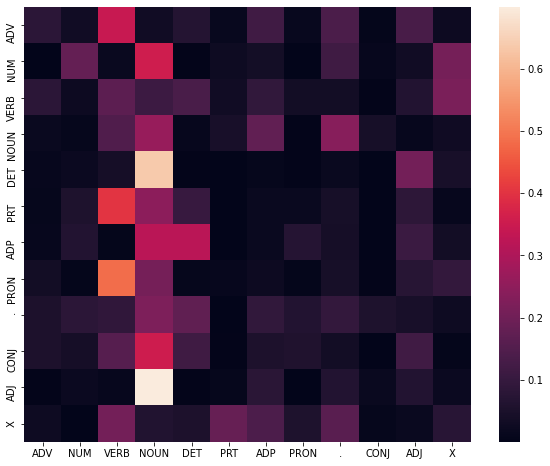

In [54]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(10, 8))
sns.heatmap(tags_df)
plt.show()

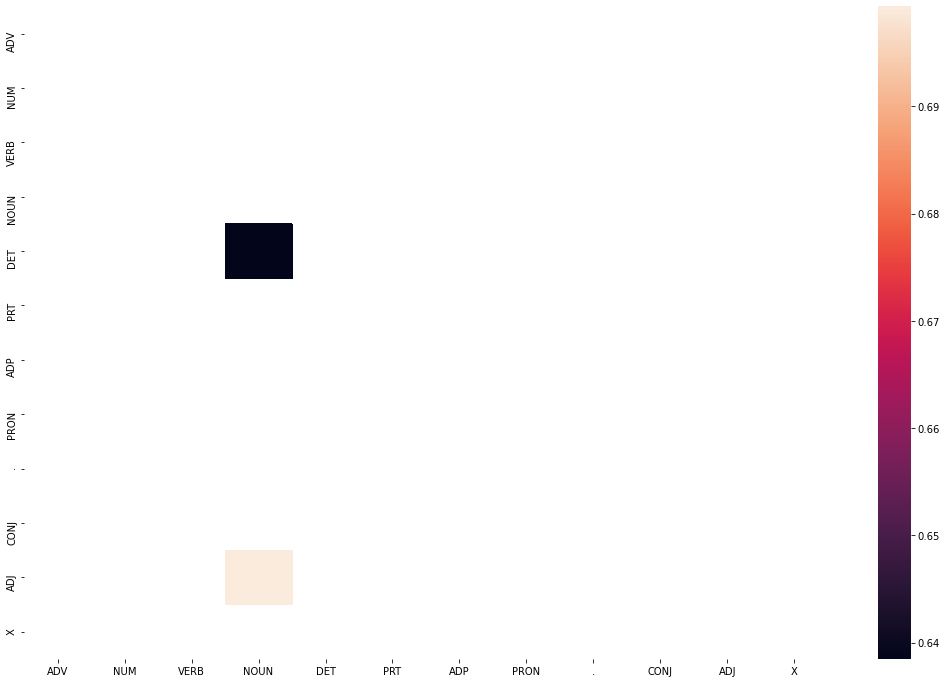

In [55]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### Nouns follow determinants and adjectives

In [85]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_wordAndTag_list):
    print("**Words to be tagged** ", words)
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    print("** T **", T)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                #print("**state[-1]** ", state[-1])
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [113]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(3)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

print(test_run_base)
print()
print(test_tagged_words)

[('Reserves', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('five', 'NUM'), ('new', 'ADJ'), ('fields', 'NOUN'), ('total', 'VERB'), ('50', 'NUM'), ('million', 'NUM'), ('barrels', 'NOUN'), ('.', '.'), ('*', 'X'), ('Think', 'VERB'), ('about', 'ADP'), ('the', 'DET'), ('good', 'NOUN'), ('0', 'X'), ('you', 'PRON'), ('can', 'VERB'), ('do', 'VERB'), ('*T*-1', 'X'), ('for', 'ADP'), ('just', 'ADV'), ('$', '.'), ('15,000', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('month', 'NOUN'), (',', '.'), ('about', 'ADV'), ('the', 'DET'), ('cost', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('mid-size', 'ADJ'), ('Chevrolet', 'NOUN'), ('or', 'CONJ'), ('two', 'NUM'), ('semesters', 'NOUN'), ('at', 'ADP'), ('a', 'DET'), ('state', 'NOUN'), ('university', 'NOUN'), ('.', '.'), ('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('some', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('managers', 'NOUN'), ('will', 'VERB'), ('take', 'VERB'), ('other', 'ADJ'), ('jobs', 'NOUN'), ('with', 'ADP'), ('First', 'NO

In [114]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

**Words to be tagged**  ['Reserves', 'for', 'the', 'five', 'new', 'fields', 'total', '50', 'million', 'barrels', '.', '*', 'Think', 'about', 'the', 'good', '0', 'you', 'can', 'do', '*T*-1', 'for', 'just', '$', '15,000', '*U*', 'a', 'month', ',', 'about', 'the', 'cost', 'of', 'a', 'mid-size', 'Chevrolet', 'or', 'two', 'semesters', 'at', 'a', 'state', 'university', '.', 'First', 'of', 'America', 'said', '0', 'some', 'of', 'the', 'managers', 'will', 'take', 'other', 'jobs', 'with', 'First', 'of', 'America', '.']
** T ** ['ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X']


In [115]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  23.4316189289093
[('Reserves', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('five', 'NUM'), ('new', 'ADJ'), ('fields', 'NOUN'), ('total', 'NOUN'), ('50', 'NUM'), ('million', 'NUM'), ('barrels', 'NOUN'), ('.', '.'), ('*', 'X'), ('Think', 'VERB'), ('about', 'ADP'), ('the', 'DET'), ('good', 'ADJ'), ('0', 'X'), ('you', 'PRON'), ('can', 'VERB'), ('do', 'VERB'), ('*T*-1', 'X'), ('for', 'ADP'), ('just', 'ADV'), ('$', '.'), ('15,000', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('month', 'NOUN'), (',', '.'), ('about', 'ADP'), ('the', 'DET'), ('cost', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('mid-size', 'ADV'), ('Chevrolet', 'NOUN'), ('or', 'CONJ'), ('two', 'NUM'), ('semesters', 'ADV'), ('at', 'ADP'), ('a', 'DET'), ('state', 'NOUN'), ('university', 'NOUN'), ('.', '.'), ('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('some', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('managers', 'NOUN'), ('will', 'VERB'), ('take', 'VERB'), ('other', 'ADJ'), ('jobs', 

In [116]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9193548387096774


In [117]:
k = zip(tagged_seq, test_run_base)
type(print(list(k)))


[(('Reserves', 'NOUN'), ('Reserves', 'NOUN')), (('for', 'ADP'), ('for', 'ADP')), (('the', 'DET'), ('the', 'DET')), (('five', 'NUM'), ('five', 'NUM')), (('new', 'ADJ'), ('new', 'ADJ')), (('fields', 'NOUN'), ('fields', 'NOUN')), (('total', 'NOUN'), ('total', 'VERB')), (('50', 'NUM'), ('50', 'NUM')), (('million', 'NUM'), ('million', 'NUM')), (('barrels', 'NOUN'), ('barrels', 'NOUN')), (('.', '.'), ('.', '.')), (('*', 'X'), ('*', 'X')), (('Think', 'VERB'), ('Think', 'VERB')), (('about', 'ADP'), ('about', 'ADP')), (('the', 'DET'), ('the', 'DET')), (('good', 'ADJ'), ('good', 'NOUN')), (('0', 'X'), ('0', 'X')), (('you', 'PRON'), ('you', 'PRON')), (('can', 'VERB'), ('can', 'VERB')), (('do', 'VERB'), ('do', 'VERB')), (('*T*-1', 'X'), ('*T*-1', 'X')), (('for', 'ADP'), ('for', 'ADP')), (('just', 'ADV'), ('just', 'ADV')), (('$', '.'), ('$', '.')), (('15,000', 'NUM'), ('15,000', 'NUM')), (('*U*', 'X'), ('*U*', 'X')), (('a', 'DET'), ('a', 'DET')), (('month', 'NOUN'), ('month', 'NOUN')), ((',', '.'),

NoneType

In [120]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('fields', 'NOUN'), (('total', 'NOUN'), ('total', 'VERB'))],
 [('the', 'DET'), (('good', 'ADJ'), ('good', 'NOUN'))],
 [(',', '.'), (('about', 'ADP'), ('about', 'ADV'))],
 [('a', 'DET'), (('mid-size', 'ADV'), ('mid-size', 'ADJ'))],
 [('two', 'NUM'), (('semesters', 'ADV'), ('semesters', 'NOUN'))]]

In [121]:
import codecs

In [122]:
#Read the text file
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [123]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [124]:
#Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### END OF SOLUTION